In [11]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [12]:
df = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [13]:
df = df[df.Site_Name=='Hermon Stream (Banias)']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [14]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [15]:
print(df.shape)
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(1402, 8)
(489, 8)
(489, 7)


In [17]:
resTrain,resTest,coeffDf = function.mlrModelResTrainTestCoeff(dfLastYearVisits)

C:\Users\Avivsa\AppData\Local\Temp\ipykernel_22604\1974364952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.dropna(inplace=True)


                            0
pm10               -151.52970
IsVacation          -88.57879
Temperature         -58.05120
is_weekend          157.86990
IsHoliday           334.74152
last_year_visitors  930.88958

rmse 651.3382599838604
std 685.817797847391


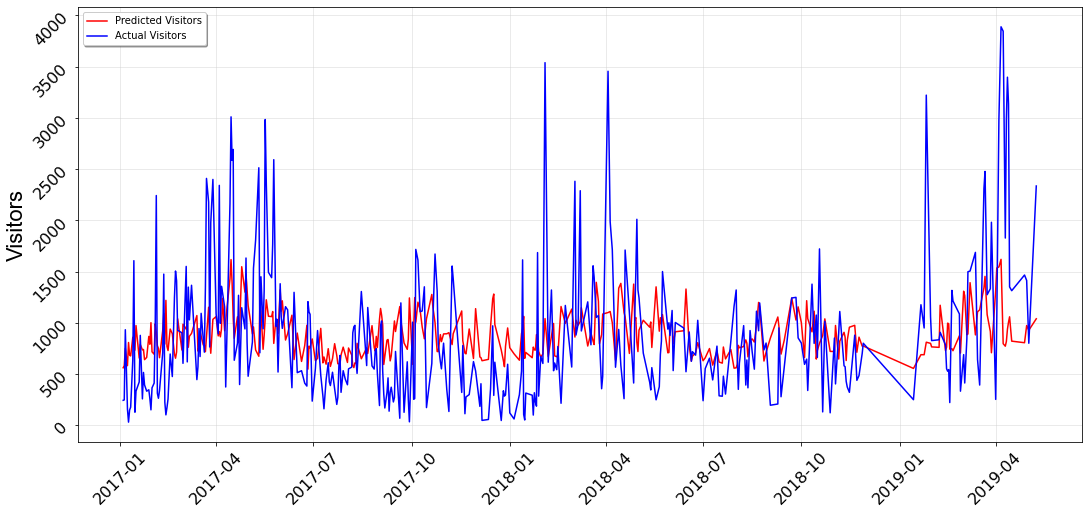

Sample rows:
             Prediction  Actual
Date                           
2018-03-06   977.157448     987
2017-04-17  1051.050751    2692
2018-09-10   966.682274     950
2019-04-01  1318.728831     252
2017-09-05   592.782209     303
2017-05-15   741.225503     941
2018-01-05   696.854355      61
2018-02-22   993.883710    1169
2017-06-30   842.041080     235
2018-08-01   560.248122    1320

rmse 540.1539894993193
std 520.0167628773802


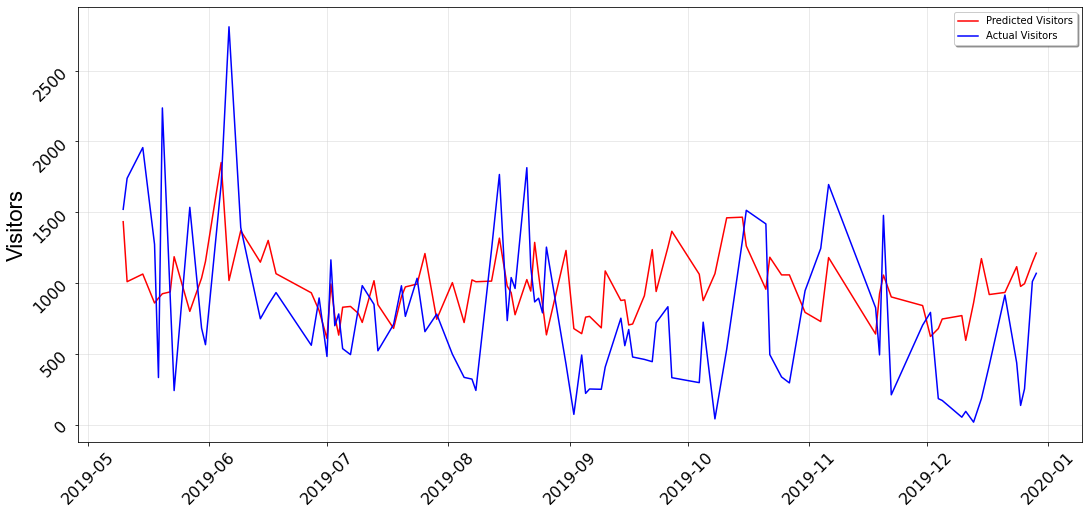

Sample rows:
             Prediction  Actual
Date                           
2019-07-14   846.483644     521
2019-12-05   745.310638     170
2019-08-07  1021.695843     321
2019-07-18   679.126209     707
2019-12-17   918.167421     418
2019-06-09  1369.164065    1391
2019-11-04   727.409833    1244
2019-11-18   639.333686     825
2019-06-27   930.365463     560
2019-11-22   901.172058     210


In [18]:
print(coeffDf)
print()

function.printRes(resTrain)
print()

function.printRes(resTest)

                     0
IsVacation  -132.98733
pm10         -48.23936
Temperature   10.16272
is_weekend   179.46603
IsHoliday    300.08791

rmse 672.2421383734916
std 685.817797847391


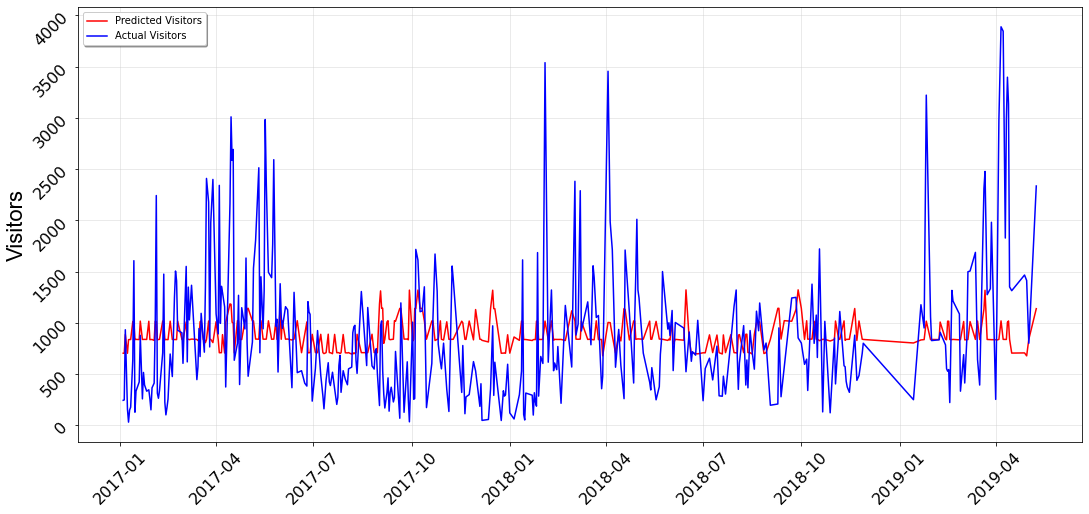

Sample rows:
             Prediction  Actual
Date                           
2017-05-25   839.573210    2592
2018-11-28   837.123733     800
2018-10-11   840.801421    1377
2017-03-21   836.596664     713
2019-04-28   705.724274    1466
2018-06-26   696.812964    1024
2017-11-28   832.997551     621
2017-11-03  1009.634745     349
2017-07-23   707.805889     203
2019-02-16  1015.141300     543

rmse 538.310320824112
std 520.0167628773802


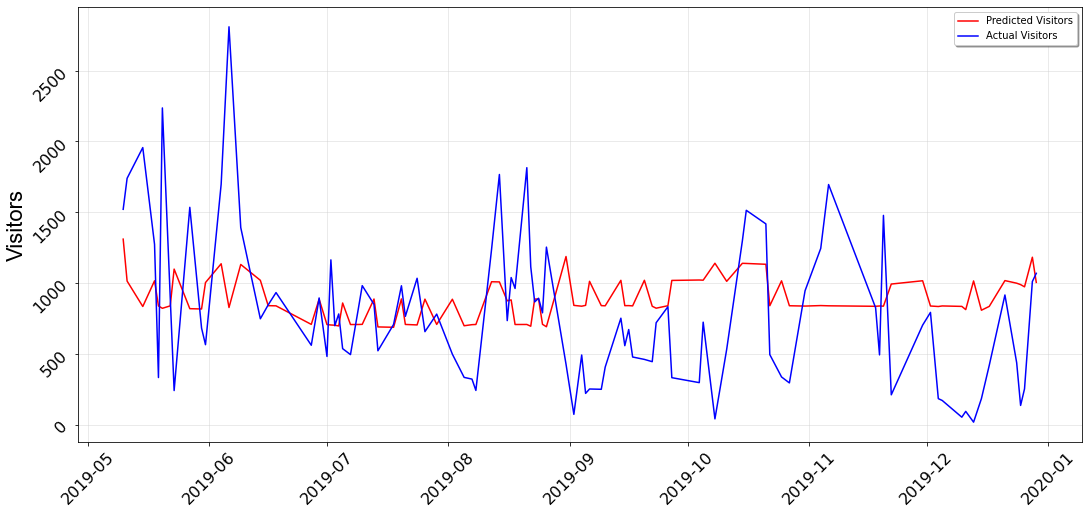

Sample rows:
             Prediction  Actual
Date                           
2019-07-04   696.247729     781
2019-08-05   697.642429     333
2019-08-17   880.131668    1038
2019-08-23   885.953181     866
2019-06-09  1130.539639    1391
2019-11-19   837.290713     492
2019-07-24   703.498732    1033
2019-08-25   707.824024     789
2019-12-13  1014.194986      17
2019-09-23   821.678918     719


In [19]:
resTrain,resTest,coeffDf = function.mlrModelResTrainTestCoeff(dfWithoutLastYearVisits)
print(coeffDf)
print()

function.printRes(resTrain)
print()

function.printRes(resTest)